In [1]:
import sys
import os
from time import time
import pymc as pm
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multinomial
from typing import List
import scipy.stats as stats
import pytensor.tensor as at
import pytensor.tensor.slinalg as sla
import pytensor
import warnings
import arviz as az
print(f"Running on PyMC v{pm.__version__}")
warnings.simplefilter(action="ignore", category=FutureWarning)
#from easydl import clear_output
from IPython.display import clear_output

Running on PyMC v5.2.0


In [2]:
from nuscenes.nuscenes import NuScenes
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
from nuscenes.prediction import PredictHelper
from nuscenes.prediction.input_representation import static_layers
from nuscenes.map_expansion.bitmap import BitMap
from nuscenes.map_expansion import arcline_path_utils
from pyquaternion import Quaternion
from nuscenes.eval.common.utils import quaternion_yaw

DATAROOT='/home/hncui/share/Nuscenes/nu_data'
nusc = NuScenes(version='v1.0-trainval', dataroot=DATAROOT, verbose=True)   # v1.0-trainval     v1.0-mini
helper = PredictHelper(nusc)
token_list = get_prediction_challenge_split("val",dataroot=DATAROOT)    # train val mini_train mini_val四个数据集
maps = static_layers.load_all_maps(helper)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 39.527 seconds.
Reverse indexing ...
Done reverse indexing in 9.0 seconds.


In [3]:
from utils_map import *

In [4]:
hyper_parameters = {
    'num_states' : 21,      #HMM相关超参数
    'acc_min' : -5,         #最小加速度
    'acc_max' : 5,          #最大加速度
    'acc_sigma' : 0.15,     #加速度方差
    'psi_min' : -0.3,       #最小转向角
    'psi_max' : 0.3,        #最大转向角
    'psi_sigma' : 0.01,     #转向角方差
    'dt' : 0.5,             #时间间隔
    'pre_calculated' : True,#是否使用提前计算好的参数
    
    #地图生成超参数

    'discretization_resolution_meters' : 1, #车道分割分辨率
    'lane_node_radius' : 5, #车道搜索后继结点半径
    'lane_direction_threshold' : np.pi / 2,  #车道后继节点方向阈值，大于该值不作为后继节点
    
    #输入数据超参数
    'data_input_radius' : 20,   #输入数据中周围移动物体检测半径
    
    #sample 超参数
    'bezier_factor' : 5, #贝塞尔距离乘系数
    'bezier_offset' : 5, #贝塞尔距离偏移系数
    'bezier_exp' : 5, #贝塞尔指数系数
    
    
}

In [5]:
Vertices_maps, Edges_maps, ordered_x_maps, ordered_y_maps, lanes_vertices = generate_maps(maps) #生成地图
#   Vertices_maps:dict(),key为地图名,value为各个地图中的节点集
#   Edges_maps:同上，边集
#   ordered_x_maps:同上，按照x坐标排序的点集
#   ordered_y_maps:同上，按照y坐标排序的点集
#   lane_vertices:dict(),key为车道token，value为车道点列表
lane_dir_diffs = set_lanes_mode(lanes_vertices) #计算车道为左转、直行、右转中的哪一个

In [6]:
X = [] #输入数据

for token in token_list:
    instance_token, sample_token = token.split('_')
    ann = helper.get_sample_annotation(instance_token, sample_token)
    X.append(ann)

In [7]:
%load_ext autoreload
%autoreload 2
from utils_sample import *
import copy
from utils_social_field import *
from utils_data_input import get_label, get_sample_input, get_moving_static_inputs
colors = {
    'animal':'aqua',
    'human':'green',
    'object':'grey',
    'cycle':'yellow',
    'vehicle':'blue',
    'lane':'tan'
}

In [8]:
gt_all, subsequences_X = get_label(helper, X)       #计算ground truth
sample_input = get_sample_input(helper, nusc, X)    #输入数据按类型分类
static_inputs, moving_inputs, moving_anns = get_moving_static_inputs(X, sample_input, helper) 
#静态障碍物，移动障碍物

In [9]:
from matplotlib.patches import Rectangle

In [10]:
from utils_HMM import get_HMM
N_STATES = hyper_parameters['num_states']
mu_a = np.linspace(-5,5,N_STATES)
mu_psi = np.linspace(-0.3, 0.3, N_STATES)
if hyper_parameters['pre_calculated']:
    P_trans_a_history = np.load('/home/hncui/data/Nuscenes/mypython/HMM_V3/P_trans_a_history_np3.16_2.npy')
    P_trans_psi_history = np.load('/home/hncui/data/Nuscenes/mypython/HMM_V3/P_trans_psi_history_np3.16_2.npy')
else:
    P_trans_a_history, P_trans_psi_history = get_HMM(nusc, helper, token_list, hyper_parameters)
p_trans_a = P_trans_a_history[-1]
p_trans_psi = P_trans_psi_history[-1]
#p_trans_a = np.load('/home/hncui/data/Nuscenes/mypython/HMM_V3/P_trans_a_3.17_1_21states.npy')
#p_trans_psi = np.load('/home/hncui/data/Nuscenes/mypython/HMM_V3/P_trans_psi_3.17_1_21states.npy')
p_trans_a = p_trans_a / p_trans_a.sum(axis = 1)
p_trans_psi = p_trans_psi / p_trans_psi.sum(axis = 1)
def np_solve_equilibrium(p_transition):
    n_states = len(p_transition)
    A = np.eye(n_states) - p_transition + np.ones(shape=(n_states,n_states))
    p_equilibrium = np.linalg.solve(A.T,np.ones(shape=(n_states)))
    return p_equilibrium
p_eq_a = np_solve_equilibrium(p_trans_a)
p_eq_psi = np_solve_equilibrium(p_trans_psi)
p_eq_a = p_eq_a / p_eq_a.sum()
p_eq_psi = p_eq_psi / p_eq_psi.sum()
true_sigma_a = np.ones(N_STATES) * 0.15
true_sigma_psi = np.ones(N_STATES) * 0.01

Running on PyMC v5.2.0


In [11]:
psi_rv = stats.norm(loc = mu_psi, scale = true_sigma_psi)
a_rv = stats.norm(loc = mu_a, scale = true_sigma_a)

model = pm.Model()
with model:
    P_trans = pm.MutableData('P_trans', p_trans_a)
    mu = pm.MutableData('mu', np.ones(N_STATES))
    sigma  = pm.MutableData('sigma', np.ones(N_STATES))
    obs_seq = pm.MutableData('obs_seq', np.ones((5,1)))
    P_init = pm.Dirichlet('P_init', a=np.ones((N_STATES,)), shape=(N_STATES,))
    a = pm.DensityDist('a', mu, sigma, P_init, P_trans, N_STATES, logp=mylogp, observed = obs_seq)

In [12]:
eps = 1e-100
v_fix_vector = np.arange(N_STATES) - (N_STATES // 2)
k_v = 1e-0
v_mean = 6.2541808327494905
a_rvs = []
psi_rvs = []
for i in range(N_STATES):
    a_rvs.append(stats.norm(loc = mu_a[i], scale = true_sigma_a[i]))
    psi_rvs.append(stats.norm(loc = mu_psi[i], scale = true_sigma_psi[i]))

In [13]:
all_agents = []
all_moving = []
all_static = []
from utils_data_input import get_field_input
for i in range(0, len(X)):
    main_agent = X[i]
    sample_token = main_agent['sample_token']
    instance_token = main_agent['instance_token']
    moving_agents = moving_anns[instance_token + '_' + sample_token]

    predict_agents = moving_agents + [main_agent]
    moving_input = copy.deepcopy(moving_inputs[instance_token + '_' + sample_token])
    get_field_input(main_agent, None, moving_input, True, helper = helper)
    static_input = static_inputs[instance_token + '_' + sample_token]

    all_agents.append(predict_agents)
    all_moving.append(moving_input)
    all_static.append(static_input)

In [14]:
def plot_agent(annotation, ax, clr = None):
    width = annotation['size'][1]
    height = annotation['size'][0]
    translation = annotation['translation']
    xy = (translation[0] - width / 2, translation[1] - height / 2)
    angle = quaternion_yaw(Quaternion(annotation['rotation'])) / np.pi * 180
    if clr is None:
        clr = 'green'
    box = Rectangle(xy, width, height, angle = angle, rotation_point = 'center', color = clr, alpha = 0.5)
    ax.add_patch(box)
    ax.set_xlim(translation[0] - 30, translation[0] + 30)
    ax.set_ylim(translation[1] - 30, translation[1] + 30)
def plot_lane(lanes_vertices, lane_token, closest_idx, ax):
    lane = lanes_vertices[lane_token]
    x = []
    y = []
    for node in lane:
        x.append(node.coors[0])
        y.append(node.coors[1])
    for i in range(len(x) - 1):
        ax.arrow(x[i], y[i], x[i+1] - x[i], y[i+1] - y[i], length_includes_head = True, head_width = 0.3, color = 'blue')
    if closest_idx is not None:
        ax.scatter(x[closest_idx], y[closest_idx])

In [15]:
from multiprocessing import Pool
model_2 = None
with Pool(16) as p:
    all_res = p.starmap(sample_predict_func_2, [(all_agents[i], all_moving[i], all_static[i], helper, 
                                               model_2, p_trans_a, mu_a, true_sigma_a, p_trans_psi, 
                                               mu_psi, true_sigma_psi, a_rv, psi_rv, p_eq_a, p_eq_psi, 
                                               maps, Vertices_maps, ordered_x_maps, ordered_y_maps, a_rvs, 
                                               psi_rvs, lanes_vertices, i)for i in range(0, len(X))])
    p.close()
    p.join()

start:0
start:142
end:0, use time:45.35716679506004
start:1
end:142, use time:27.82425727788359
start:143
start:284
end:1, use time:46.230456235352904
start:2
end:143, use time:54.697016555815935
start:144
end:284, use time:40.08939629374072
start:285
start:426
end:2, use time:47.532663374207914
start:3
end:285, use time:41.55812837276608
start:286
start:568
end:144, use time:57.78819379815832
start:145
end:426, use time:57.94771098718047
start:427
end:3, use time:68.19605183508247
start:4
start:710
end:568, use time:45.36660301499069
start:569
end:286, use time:67.91421284805983
start:287
end:145, use time:60.18045106716454
start:146
end:427, use time:61.00951848458499
start:428
start:852
end:569, use time:47.50074262870476
start:570
end:4, use time:73.84323754208162
start:5
start:994
end:146, use time:60.51165402820334
start:147
end:852, use time:46.241463674232364
start:853
end:287, use time:68.37210342986509
start:288
end:428, use time:60.04664264200255
start:429
end:570, use time:

In [16]:
gt_all = np.array(gt_all)
gt_x = gt_all[:,:,0]
gt_y = gt_all[:,:,1]
gt_x.shape, gt_y.shape

((9041, 12), (9041, 12))

In [17]:
main_x = []
main_y = []
c_gt_x = []
c_gt_y = []
idxes = []
for i in range(len(all_res)):
    if type(all_res[i][0]) == type(None):
        print(i)
    else:
        main_x.append(all_res[i][0])
        main_y.append(all_res[i][1])
        c_gt_x.append(gt_x[i])
        c_gt_y.append(gt_y[i])
        idxes.append(i)


In [19]:
ans_x = np.array(main_x)
ans_y = np.array(main_y)
np.save('ans_x_5_30.npy', ans_x)
np.save('ans_y_5_30.npy', ans_y)

In [20]:
min_ade1000 = []
for i in range(len(main_x)):
    xs = main_x[i]
    ys = main_y[i]
    x_diff = xs - c_gt_x[i]
    y_diff = ys - c_gt_y[i]
    ade = np.sqrt(x_diff ** 2 + y_diff ** 2)
    min_ade1000.append(ade.mean(axis = 1).min())

min_ade1000 = np.array(min_ade1000)

In [21]:
min_ade1000, min_ade1000.mean()

(array([0.57067934, 0.44269604, 0.464674  , ..., 0.43648646, 0.63598597,
        0.48646625]),
 0.7004939082740762)

In [ ]:
figsize(15,15)
for i in range(len(main_x)):
    total_i = i * 100
    fig, ax = plt.subplots()
    idx = -1
    predict_agents = all_agents[total_i]
    ans_nodes = all_res[i][0]
    node = ans_nodes[1]
    plot_agent(predict_agents[idx], ax)
    candidate = node.candidate_lanes[idx]
    lanes_token = list(node.candidate_lanes[idx].keys())
    temp_xy = np.array(predict_agents[idx]['translation'][:2])
    v = node.v[0][idx]
    yaw = node.yaw[0][idx]
    for j in range(len(lanes_token)):
        lane_token = lanes_token[j]
        lane = lanes_vertices[lane_token]
        lane_idx = candidate[lane_token][1]
        plot_lane(lanes_vertices, lane_token, lane_idx, ax)
        b_x, b_y = generate_bezier(temp_xy, v, yaw, lane[lane_idx])
        ax.text(lane[lane_idx].coors[0], lane[lane_idx].coors[1], f'{j}')
        ax.plot(b_x, b_y)
    ax.plot(gt_x[total_i], gt_y[total_i], color = 'red')
    ax.scatter(main_x[i], main_y[i], s= 1, alpha=0.5)
    fig.savefig('./predict_3.20_3_5/fig_{}_pred_all.png'.format(total_i))
    plt.close()

In [ ]:
def plot_scene(ann, helper):
    fig, ax = plt.subplots()
    anns = helper.get_annotations_for_sample(ann['sample_token'])
    for t_ann in anns:
        if t_ann['token'] == ann['token']:
            color = 'red'
        else:
            color = 'green'
        plot_agent(t_ann, ax, color)
    
    translation = ann['translation']
    ax.set_xlim(translation[0] - 50, translation[0] + 50)
    ax.set_ylim(translation[1] - 50, translation[1] + 50)
    map_name = helper.get_map_name_from_sample_token(ann['sample_token'])
    Vertices = Vertices_maps[map_name]
    Vertices_ordered_x = ordered_x_maps[map_name]
    Vertices_ordered_y = ordered_y_maps[map_name]
    lanes_token = get_lanes_in_radius(translation[0], translation[1], 50, Vertices, Vertices_ordered_x, Vertices_ordered_y)
    
    for j in range(len(lanes_token)):
        lane_token = lanes_token[j]
        plot_lane(lanes_vertices, lane_token, None, ax)

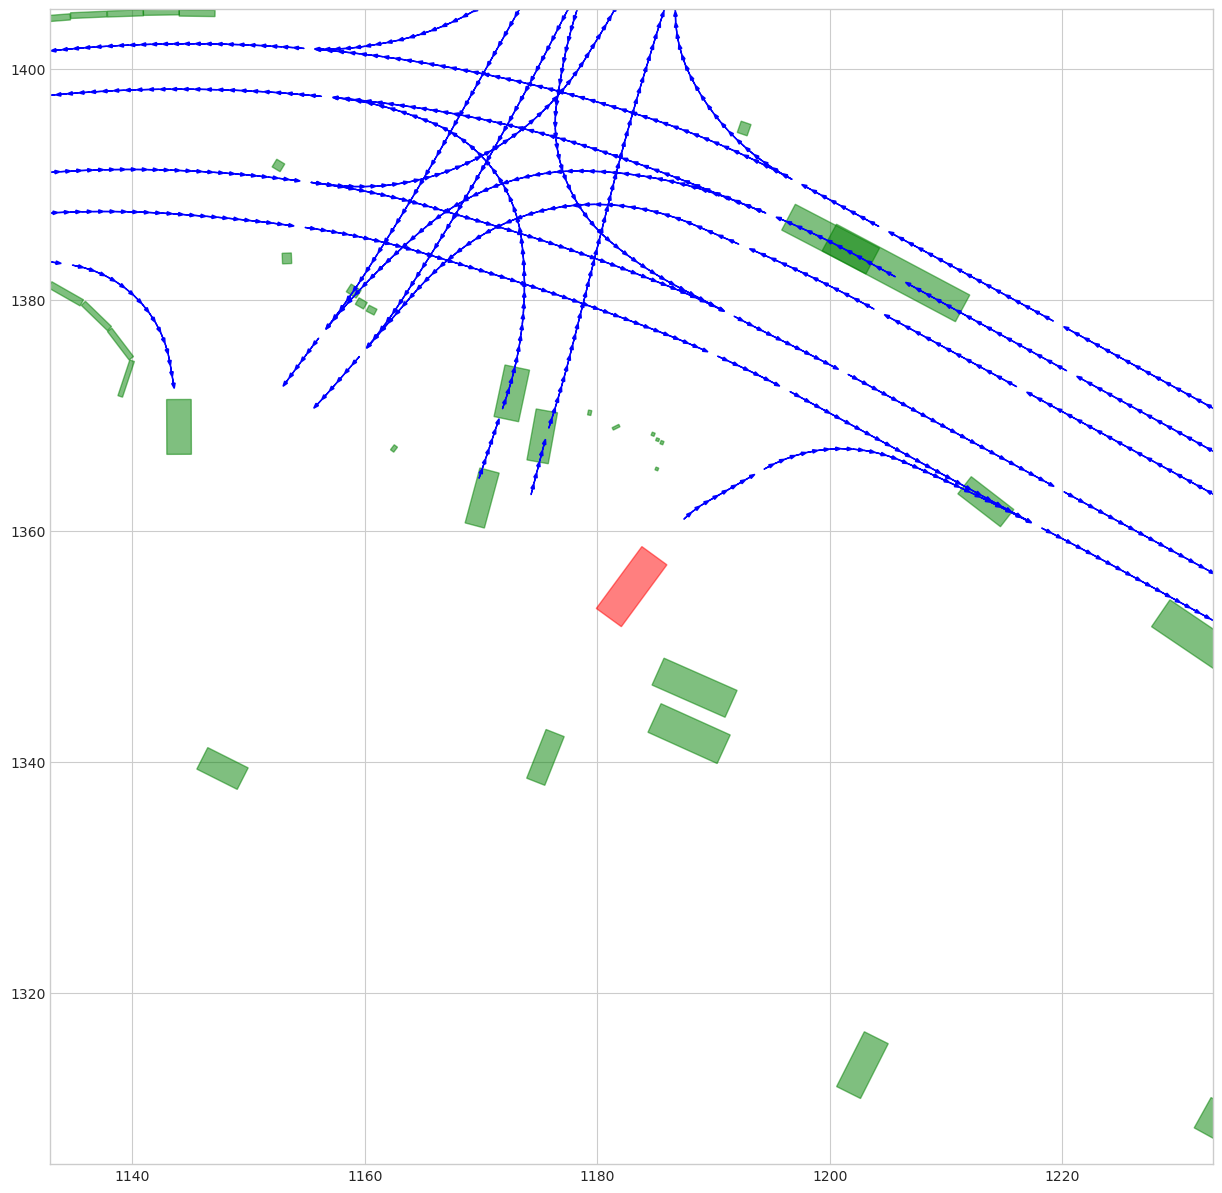

In [ ]:
figsize(15,15)
plot_scene(X[1190], helper)

In [ ]:
pred_x = main_x[0]
pred_y = main_y[0]
num_samples = len(pred_x)
pred_nodes = np.stack([pred_x, pred_y], axis = 2).reshape(num_samples, -1)

In [22]:
figsize(15,15)
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import LocalOutlierFactor
pred_5_x = []
pred_5_y = []
pred_10 = []
n_clusters = 5
n_res = 5
for i in range(len(main_x)):
    #clear_output()
    #print(i)
    
    pred_x = main_x[i]
    pred_y = main_y[i]
    num_samples = len(pred_x)
    pred_nodes = np.stack([pred_x, pred_y], axis = 2).reshape(num_samples, -1)
    
    clustering = AgglomerativeClustering(n_clusters = n_clusters, linkage = 'ward').fit(pred_nodes)
    labels = clustering.labels_
    agent_x = []
    agent_y = []
    rank = []
    for j in range(n_clusters):
        rank.append(((labels == j).sum(), j))
    rank = sorted(rank, reverse = True)
    for j in range(n_res):
        mask = labels == rank[j][1]
        temp_x = pred_x[mask]
        temp_x = temp_x.mean(axis = 0)
        temp_y = pred_y[mask]
        temp_y = temp_y.mean(axis = 0)
        agent_x.append(temp_x)
        agent_y.append(temp_y)
    pred_5_x.append(agent_x)
    pred_5_y.append(agent_y)
 

In [23]:
x_diffs = (np.array(pred_5_x) - np.expand_dims(c_gt_x, 1))
y_diffs = (np.array(pred_5_y) - np.expand_dims(c_gt_y, 1))
ade_5 = np.sqrt(x_diffs ** 2 + y_diffs ** 2)
ade_5.mean(axis = 2).min(axis = 1).mean()

1.848392407087234

In [24]:
ade_5.mean(axis = 2).min(axis = 1)

array([1.32187181, 0.86042516, 0.9178086 , ..., 1.69236279, 1.26573069,
       1.57844009])

In [25]:
figsize(15,15)
from sklearn.cluster import AgglomerativeClustering

pred_10_x = []
pred_10_y = []
pred_10 = []
n_clusters = 10
n_res = 10
for i in range(len(main_x)):
    #clear_output()
    #print(i)

    pred_x = main_x[i]
    pred_y = main_y[i]
    num_samples = len(pred_x)
    pred_nodes = np.stack([pred_x, pred_y], axis = 2).reshape(num_samples, -1)
    
    clustering = AgglomerativeClustering(n_clusters = n_clusters, linkage = 'ward').fit(pred_nodes)
    labels = clustering.labels_
    agent_x = []
    agent_y = []
    rank = []
    for j in range(n_clusters):
        rank.append(((labels == j).sum(), j))
    rank = sorted(rank, reverse = True)
    for j in range(n_res):
        mask = labels == rank[j][1]
        temp_x = pred_x[mask]
        temp_x = temp_x.mean(axis = 0)
        temp_y = pred_y[mask]
        temp_y = temp_y.mean(axis = 0)
        agent_x.append(temp_x)
        agent_y.append(temp_y)
    pred_10_x.append(agent_x)
    pred_10_y.append(agent_y)
 

In [26]:
x_diffs = (np.array(pred_10_x) - np.expand_dims(c_gt_x, 1))
y_diffs = (np.array(pred_10_y) - np.expand_dims(c_gt_y, 1))
ade_10 = np.sqrt(x_diffs ** 2 + y_diffs ** 2)
ade_10.mean(axis = 2).min(axis = 1).mean()

1.3777156983450647

In [ ]:
pred_5_x = np.array(pred_5_x)
pred_5_y = np.array(pred_5_y)
pred_10_x = np.array(pred_10_x)
pred_10_y = np.array(pred_10_y)

In [ ]:
figsize(15,15)
color = ['b','g','r','m','k','c','y']
def get_histroy(ins_sample_token):
    instance_token, sample_token = ins_sample_token.split('_')
    past_xy_global = helper.get_past_for_agent(instance_token, sample_token, seconds=2, in_agent_frame=False)
    past_xy_global = past_xy_global[::-1]
    ann = helper.get_sample_annotation(instance_token, sample_token)
    x_y = np.array([ann['translation'][:2]])
    return np.concatenate([past_xy_global, x_y], axis = 0)
for idx in range(len(X)):
    ann = X[idx]
    instance_token, sample_token = token_list[idx].split('_')
    ann = helper.get_sample_annotation(instance_token, sample_token)
    map_name = helper.get_map_name_from_sample_token(sample_token)
    Vertices_ordered_x = ordered_x_maps[map_name]
    Vertices_ordered_y = ordered_y_maps[map_name]
    Vertices = Vertices_maps[map_name]
    Edges = Edges_maps[map_name]
    for j in range(len(pred_5_x[idx])):
        plt.scatter(pred_5_x[idx][j].reshape(-1), pred_5_y[idx][j].reshape(-1), s = 5)
    plt.scatter(gt_x[idx], gt_y[idx], marker='*', s = 50)
    x_lim = plt.xlim()
    y_lim = plt.ylim()
    history = get_histroy(token_list[idx])
    nodes = get_nodes_in_radius(*ann['translation'][:2], 50, Vertices, Vertices_ordered_x, Vertices_ordered_y)
    plt.scatter(history[:,0], history[:, 1], marker= 'x', s = 50)

    for node in nodes:
        node_1 = Vertices[node]
        #plt.scatter(node_1.coors[0], node_1.coors[1])
        for i in node_1.next:
            node_2 = Vertices[i]
            if node_1.lane_token == node_2.lane_token:
                plt.arrow(node_1.coors[0], node_1.coors[1], node_2.coors[0] - node_1.coors[0], node_2.coors[1] - node_1.coors[1], length_includes_head = True, head_width = 0.3, color = color[0])
            #else:
            #    plt.arrow(node_1.coors[0], node_1.coors[1], node_2.coors[0] - node_1.coors[0], node_2.coors[1] - node_1.coors[1], length_includes_head = True, head_width = 0.3, color = color[1])
    plt.xlim(gt_x[idx][0] - 30, gt_x[idx][0] + 30)
    plt.ylim(gt_y[idx][0] - 30, gt_y[idx][0] + 30)
    plt.savefig('./predict_3.20_3_4/fig_{}_pred_5.png'.format(idx))
    plt.close()
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [ ]:
figsize(15,15)
color = ['b','g','r','m','k','c','y']
def get_histroy(ins_sample_token):
    instance_token, sample_token = ins_sample_token.split('_')
    past_xy_global = helper.get_past_for_agent(instance_token, sample_token, seconds=2, in_agent_frame=False)
    past_xy_global = past_xy_global[::-1]
    ann = helper.get_sample_annotation(instance_token, sample_token)
    x_y = np.array([ann['translation'][:2]])
    return np.concatenate([past_xy_global, x_y], axis = 0)
for idx in range(len(X)):
    ann = X[idx]
    instance_token, sample_token = token_list[idx].split('_')
    ann = helper.get_sample_annotation(instance_token, sample_token)
    map_name = helper.get_map_name_from_sample_token(sample_token)
    Vertices_ordered_x = ordered_x_maps[map_name]
    Vertices_ordered_y = ordered_y_maps[map_name]
    Vertices = Vertices_maps[map_name]
    Edges = Edges_maps[map_name]
    for j in range(len(pred_10_x[idx])):
        plt.scatter(pred_10_x[idx][j].reshape(-1), pred_10_y[idx][j].reshape(-1), s = 5)
    plt.scatter(gt_x[idx], gt_y[idx], marker='*', s = 50)
    x_lim = plt.xlim()
    y_lim = plt.ylim()
    history = get_histroy(token_list[idx])
    nodes = get_nodes_in_radius(*ann['translation'][:2], 50, Vertices, Vertices_ordered_x, Vertices_ordered_y)
    plt.scatter(history[:,0], history[:, 1], marker= 'x', s = 50)

    for node in nodes:
        node_1 = Vertices[node]
        #plt.scatter(node_1.coors[0], node_1.coors[1])
        for i in node_1.next:
            node_2 = Vertices[i]
            if node_1.lane_token == node_2.lane_token:
                plt.arrow(node_1.coors[0], node_1.coors[1], node_2.coors[0] - node_1.coors[0], node_2.coors[1] - node_1.coors[1], length_includes_head = True, head_width = 0.3, color = color[0])
            #else:
            #    plt.arrow(node_1.coors[0], node_1.coors[1], node_2.coors[0] - node_1.coors[0], node_2.coors[1] - node_1.coors[1], length_includes_head = True, head_width = 0.3, color = color[1])
    plt.xlim(gt_x[idx][0] - 30, gt_x[idx][0] + 30)
    plt.ylim(gt_y[idx][0] - 30, gt_y[idx][0] + 30)
    plt.savefig('./predict_3.20_3_4/fig_{}_pred_10.png'.format(idx))
    plt.close()
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
